# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [3]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### 2. Define the Architecture of the Policy

In [6]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs) #Creates a distrubition that achieve the probaiblies of each action, so that we can draw from it later 
        action = m.sample() #draw a random number (idx here) given the distubition aboved which is based on the prob.
        print(action.item(), m.log_prob(action))
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [7]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        '''
        we are taking negative of (-log_prob*R) and perform gradient descent. (policy_loss.backward())
        But since all of the gradients have negative sign 
        and gradient descent subtracts the gradients from our parameters, 
        2 negative signs and we have a positive gradient now.
        So, we end up taking a step in the direction of the gradients. (Gradient Ascent)
        '''
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R) 
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        
    return scores
    
scores = reinforce()

1 tensor([-0.6540])
1 tensor([-0.6578])
1 tensor([-0.6680])
0 tensor([-0.7120])
0 tensor([-0.7189])
0 tensor([-0.7311])
0 tensor([-0.7355])
1 tensor([-0.6554])
1 tensor([-0.6524])
0 tensor([-0.7295])
0 tensor([-0.7360])
0 tensor([-0.7353])
0 tensor([-0.7086])
1 tensor([-0.7099])
1 tensor([-0.6791])
1 tensor([-0.6534])
0 tensor([-0.7342])
1 tensor([-0.6533])
1 tensor([-0.6539])
1 tensor([-0.6618])
0 tensor([-0.7147])
0 tensor([-0.7258])
0 tensor([-0.7345])
0 tensor([-0.7384])
1 tensor([-0.6728])
0 tensor([-0.7381])
1 tensor([-0.6723])
0 tensor([-0.7377])
0 tensor([-0.7147])
1 tensor([-0.7022])
0 tensor([-0.7136])
1 tensor([-0.7043])
0 tensor([-0.7118])
0 tensor([-0.6793])
0 tensor([-0.6379])
1 tensor([-0.7954])
1 tensor([-0.7583])
0 tensor([-0.6652])
1 tensor([-0.7655])
1 tensor([-0.7312])
1 tensor([-0.6973])
0 tensor([-0.7121])
1 tensor([-0.7041])
1 tensor([-0.6827])
1 tensor([-0.6628])
0 tensor([-0.7250])
0 tensor([-0.7167])
0 tensor([-0.6878])
1 tensor([-0.7361])
0 tensor([-0.7118])


KeyboardInterrupt: 

### 4. Plot the Scores

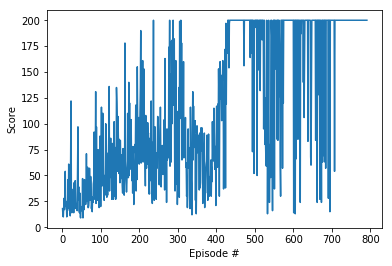

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [ ]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()